In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
from bertopic import BERTopic
from hdbscan import HDBSCAN
from umap import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
import torch
import pandas as pd
import time
from tqdm import tqdm
from glob import glob
import numpy as np
import sqlite3
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm



/home/students/s328743/.conda/envs/bertopic_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# DA PORTATILE SCOMMENTARE QUESTO
#extracted_dir = os.path.join("..", "material", "extracted")

#------------------------------------------------
#DA JUPYTER CUSTER SCOMMENTARE QUESTO
extracted_dir = os.path.expanduser("~/telegram_2024/usc-tg-24-us-election/extracted")

In [3]:
chats_path = '../material/chats.db'
conn = sqlite3.connect(chats_path)
cursor=conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables=cursor.fetchall()

# ========================
# 1. Leggi chats.db (SQLite)
# ========================

print("Tables in DB:", tables)
try:
    df_chats = pd.read_sql_query("SELECT * FROM chats", conn)
    df_chats =df_chats.drop_duplicates(subset='type_and_id')
    print("number of unique chats", len(df_chats))
    print("chats.db - Tabella 'chats'")
    print(df_chats.head())
except Exception as e:
    print("Errore nel leggere la tabella:", e)

conn.close()

# ========================
# 2. Leggi discovery_edges.csv.gz
# ========================
try:
    df_edges = pd.read_csv('../material/discovery_edges.csv.gz')
    df_edges = df_edges.drop_duplicates(subset='type_and_id')
    print("✅ discovery_edges.csv.gz, \n" \
    "Il timestamp da l'ultima volta che hanno visitato quel gruppo ma questo significa che non è davvero indicativo di una timeline \n")
    print(df_edges.head())
except Exception as e:
    print("Errore nel leggere discovery_edges:", e)

# ========================
# 3. Leggi first_nodes.csv.gz
# ========================
try:
    df_first_nodes = pd.read_csv('../material/first_nodes.csv.gz')
    print("number of non unique first nodes", len(df_first_nodes))
    df_first_nodes = df_first_nodes.drop_duplicates(subset='type_and_id')
    print("✅ first_nodes.csv.gz")
    print(df_first_nodes.head())
    print("number of unique first nodes", len(df_first_nodes))
except Exception as e:
    print("Errore nel leggere first_nodes:", e)


Tables in DB: [('chats',)]
number of unique chats 127141
chats.db - Tabella 'chats'
           type_and_id                   token                  parent  \
0                 None  [keyword] thedemocrats                    None   
40  channel_1889806290         thedemocratskmf  [keyword] thedemocrats   
41  channel_1413288788       thedemocratsindia  [keyword] thedemocrats   
42  channel_1709284265           thedemocratsa  [keyword] thedemocrats   
43  channel_1807294270             democratsmv  [keyword] thedemocrats   

       timestamp  
0   1.722583e+09  
40  1.728093e+09  
41  1.728093e+09  
42  1.728093e+09  
43  1.728093e+09  
✅ discovery_edges.csv.gz, 
Il timestamp da l'ultima volta che hanno visitato quel gruppo ma questo significa che non è davvero indicativo di una timeline 

          type_and_id              parent     timestamp
0  channel_1306559115  channel_1840578235  1.722586e+09
1  channel_2036850729  channel_1840578235  1.722586e+09
2  channel_1941222046  channel_18

In [4]:
print("type_and_id unique in df_first_nodes" + str(df_first_nodes.type_and_id.nunique()))
print("type_and_id in df_first_nodes" + str(len(df_first_nodes)))
print("type_and_id NaN in df_first_nodes " + str(df_first_nodes['type_and_id'].isna().sum()))

type_and_id unique in df_first_nodes247
type_and_id in df_first_nodes247
type_and_id NaN in df_first_nodes 0


In [5]:
# Fare preprocessing dei testi:
import os
import re
from typing import Callable, Union

# import spacy
# from sklearn.feature_extraction.text import TfidfVectorizer
# from tqdm import tqdm
from unidecode import unidecode
import langdetect


class PreProcessing:
    """Class for performing text preprocessing operations.

    Args:
        noadverbs (bool, optional): Flag to remove adverbs from the text. Defaults to False.
        noadjectives (bool, optional): Flag to remove adjectives from the text. Defaults to False.
        noverbs (bool, optional): Flag to remove verbs from the text. Defaults to False.
        noentities (bool, optional): Flag to remove named entities from the text. Defaults to False.
        language (str, optional): Language for the Spacy model. Defaults to 'en'.
        remove_list (bool, optional): Flag to remove a list of words from the text. Defaults to False.

    Attributes:
        noadverbs (bool): Flag to remove adverbs from the text.
        noadjectives (bool): Flag to remove adjectives from the text.
        noverbs (bool): Flag to remove verbs from the text.
        noentities (bool): Flag to remove named entities from the text.
        language (str): Language for the Spacy model.
        remove_list (bool): Flag to remove a list of words from the text.
        punctuation (str): Regular expression pattern for removing punctuation.
        nlp (spacy.Language): Spacy language model.
        stopwords (list): List of stopwords.

    Methods:
        lowercase_unidecode: Converts text to lowercase and removes diacritics.
        remove_urls: Removes URLs from the text.
        remove_tweet_marking: Removes Twitter mentions and hashtags from the text.
        remove_punctuation: Removes punctuation from the text.
        remove_repetion: Removes repeated words from the text.
        append_stopwords_list: Appends additional stopwords to the existing list.
        remove_stopwords: Removes stopwords from the text.
        remove_n: Removes words with length less than or equal to n from the text.
        remove_numbers: Removes or filters out numbers from the text.
        remove_gerund: Removes gerund endings from verbs in the text.
        remove_infinitive: Removes infinitive endings from verbs in the text.
        filter_by_idf: Filters out words based on their inverse document frequency.

    """

    def __init__(self, noadverbs: bool = False, noadjectives: bool = False, noverbs: bool = False,
                 noentities: bool = False, language: str = 'en', remove_list: bool = False,stopwords=[]):
        """Initialize the PreProcessing object.

        Args:
            noadverbs (bool, optional): Flag to indicate whether to remove adverbs. Defaults to False.
            noadjectives (bool, optional): Flag to indicate whether to remove adjectives. Defaults to False.
            noverbs (bool, optional): Flag to indicate whether to remove verbs. Defaults to False.
            noentities (bool, optional): Flag to indicate whether to remove named entities. Defaults to False.
            remove_list (bool, optional): Flag to indicate whether to remove stopwords. Defaults to False.
        """
        self.noadverbs = noadverbs
        self.noadjectives = noadjectives
        self.noverbs = noverbs
        self.noentities = noentities
        self.remove_list = remove_list
        self.punctuation = (
                r'\(|!|"|#|\$|%|&|\'|\(|\)|\*|\+|,|-|\.|\/|'
                r':|;|<|=|>|\?|\@|\[|\]|\^|_|`|\{|\}|~|\||'
                r'\r\n|\n|\r|\\\)'
        )
        # self.nlp = self._load_spacy_model(language)
        # self.stopwords = [unidecode(x).lower() for x in list(self.nlp.Defaults.stop_words)]
        self.stopwords=stopwords



    
    def _process_text(self, text: Union[str, list], function: Callable) -> Union[str, list]:

        if isinstance(text, str):
            return function(text)
        elif isinstance(text, list):
            return [function(x) for x in text]
        return ''
    
    
    def lowercase_unidecode(self, text: Union[str, list]) -> Union[str, list]:
        """Convert the given text to lowercase and remove any diacritical marks (accents).

        Args:
            text (Union[str, list]): The text to be processed. It can be either a string or a list of strings.

        Returns:
            Union[str, list]: The processed text. If the input is a string, the output will be a string. If the input is a list,
            the output will be a list of strings.

        Example:
            >>> pre_processor = PreProcessor()
            >>> text = "Café"
            >>> pre_processor.lowercase_unidecode(text)
            'cafe'
        """
        from unidecode import unidecode
        text = self._process_text(text, lambda value: value.lower())
        text = self._process_text(text, unidecode)
        return text

    def remove_urls(self, text: Union[str, list]) -> Union[str, list]:
        """Removes URLs from the given text or list of texts.

        Args:
            text (Union[str, list]): The text or list of texts from which to remove URLs.

        Returns:
            Union[str, list]: The text or list of texts with URLs removed.

        """
        return self._process_text(text, lambda value: re.sub(r'http\S+ *', '', value).strip())

    def remove_tweet_marking(self, text: Union[str, list]) -> Union[str, list]:
        """Removes tweet markings (e.g., @mentions and #hashtags) from the given text.

        Args:
            text (Union[str, list]): The text or list of texts to process.

        Returns:
            Union[str, list]: The processed text or list of processed texts with tweet markings removed.
        """
        return self._process_text(text, lambda value: re.sub(r'(@|#)\S+ *', '', value).strip())

    def remove_html_tags(self, text: Union[str, list]) -> Union[str, list]:
        """Removes HTML tags from the given text.

        Args:
            text (Union[str, list]): The text or list of texts to process.

        Returns:
            Union[str, list]: The processed text or list of processed texts with HTML tags removed.
        """
        return self._process_text(text, lambda value: re.sub(r'<.*?> *', '', value).strip())

    def remove_punctuation(self, text: Union[str, list]) -> Union[str, list]:
        """Removes punctuation from the given text.

        Args:
            text (Union[str, list]): The text from which punctuation needs to be removed.

        Returns:
            Union[str, list]: The text with punctuation removed.
        """
        text = self._process_text(text, lambda value: re.sub(self.punctuation, ' ', value))
        text = self._process_text(text, lambda value: re.sub(' {2,}', ' ', value).strip())
        return text

    def remove_repetition(self, text: Union[str, list]) -> Union[str, list]:
        """Removes repeated words in the given text.

        Args:
            text (Union[str, list]): The input text or list of words.

        Returns:
            Union[str, list]: The processed text with repeated words removed.

        """
        return self._process_text(text, lambda value: re.sub(r'\b(\w+)\s+\1\b', r'\1', value))

    def append_stopwords_list(self, stopwords: list) -> None:
        """Appends additional stopwords to the existing list of stopwords.

        Parameters:
        stopwords (list): A list of stopwords to be appended.

        """
        self.stopwords.extend(stopwords)

    def remove_stopwords(self, text: Union[str, list]) -> Union[str, list]:
        """Removes stopwords from the given text.

        Args:
            text (Union[str, list]): The input text from which stopwords need to be removed.

        Returns:
            Union[str, list]: The processed text with stopwords removed.

        """
        return self._process_text(text, lambda value: re.sub(rf'\b({"|".join(self.stopwords)})\b *', '', value).strip())

    

    def remove_n(self, text: Union[str, list], n: int) -> Union[str, list]:
        """Removes words of length 1 to n followed by the word 'pri' from the given text.

        Args:
            text (Union[str, list]): The input text or list of texts to process.
            n (int): The maximum length of words to remove.

        Returns:
            Union[str, list]: The processed text or list of processed texts.

        """
        return self._process_text(text, lambda value: re.sub(rf'(\b|^)\w{{1,{n}}}(\b|$) ?', '', value).strip())

    def remove_numbers(self, text: Union[str, list], mode: str = 'replace') -> Union[str, list]:
        """Removes or replaces numbers in the given text.

        Args:
            text (Union[str, list]): The input text or list of texts.
            mode (str, optional): The mode of operation. Defaults to 'replace'.
                - 'filter': Removes the numbers from the text.
                - 'replace': Replaces the numbers with an empty string.

        Returns:
            Union[str, list]: The processed text or list of processed texts.
        """
        if mode == "filter":
            return self._process_text(text, lambda value: '' if re.search('[0-9]', value) else value)
        elif mode == "replace":
            return self._process_text(text, lambda value: re.sub('[0-9] *', '', value))

    def remove_gerund(self, text: Union[str, list]) -> Union[str, list]:
        """Removes the gerund form '-ndo' from the given text.

        Args:
            text (Union[str, list]): The input text or list of texts to process.

        Returns:
            Union[str, list]: The processed text with the gerund form removed.

        """
        return self._process_text(text, lambda value: re.sub(r'ndo\b', '', value))

    def remove_infinitive(self, text: Union[str, list]) -> Union[str, list]:
        """Removes the infinitive form of verbs from the given text.

        Args:
            text (Union[str, list]): The input text or list of texts to process.

        Returns:
            Union[str, list]: The processed text with infinitive forms removed.

        """
        return self._process_text(text, lambda value: re.sub(r'r\b', '', value))
    
    
    def detect_language(self,text):
        import langdetect
        try:
            d=langdetect.detect_langs(text)
            # Trasforma la lista in un dizionario
            langs_dict = {lang.lang: lang.prob for lang in d}
            best_lang=max(langs_dict,key=langs_dict.get)
            best_lang=best_lang if langs_dict[best_lang]>=0.7 else 'unk'
            return best_lang    
        except langdetect.LangDetectException as e:
            return 'unk'
        return None


from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)

# here the funziona to call to preprocess the text
def preprocess_text(text,stopwords=stopwords):
    try: 
        pp=PreProcessing(language='en',stopwords=stopwords)

        # Preprocessing pipeline
        text_low = pp.lowercase_unidecode(text)

        lang = pp.detect_language(text_low)
        if lang in ('unk', None):
            return ("", "unk")

        text_clean = pp.remove_stopwords(text_low)
        text_clean = pp.remove_tweet_marking(text_clean)
        text_clean = pp.remove_urls(text_clean)
        text_clean = pp.remove_repetition(text_clean)
        text_clean = pp.remove_punctuation(text_clean)
        text_clean = pp.remove_numbers(text_clean)
        text_clean = pp.remove_n(text_clean, n=3)
        result = (text_clean, lang)
    except Exception:
        return ("", "unk")
    if not (isinstance(result, tuple) and len(result) == 2):
        print("----\n-----\n error in preprocess_text ------\n------\n")
        result = ("", "unk")
    return result


In [6]:
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import os
import pandas as pd
from glob import glob

os.environ["TOKENIZERS_PARALLELISM"] = "false"

pp2 = PreProcessing(language='en', stopwords=stopwords)

# Path to the final preprocessed file
output_path_preprocessed_messages = "../material/preprocessed_messages.tsv.gz"
output_path_channels_without_message = "../material/channels_without_message.tsv.gz"

channels_without_message = []

# If the file exists, load it directly and skip the rest
if os.path.exists(output_path_preprocessed_messages):
    print("--- File already exists: {}".format(output_path_preprocessed_messages))
    df_preprocessed_non_empty_channels = pd.read_csv(output_path_preprocessed_messages, sep='\t', compression='gzip')
    print("--- File loaded with {} preprocessed messages.".format(len(df_preprocessed_non_empty_channels)))
else:
    print("--- File not found, proceeding with preprocessing...")

    def process_file(args):
        file, channel_id, token = args
        try:
            df = pd.read_csv(file, sep='\t', compression='gzip', usecols=['text', 'timestamp'])
            df = df.dropna(subset=['text'])
            df['text'] = df['text'].astype(str)
            pairs = df['text'].apply(preprocess_text)
            
            #count the touple of length 2 (valids) and the void ones (invalids)
            valid   = sum(1 for p in pairs if isinstance(p, tuple) and len(p)==2)
            invalid = len(pairs) - valid
            #decomment to debug
            #print(f"--- valid pairs: {valid}, invalid pairs: {invalid}")
            #print("pairs", pairs)
            df['text_preprocessed'] = [p[0] for p in pairs]
            df['language']          = [p[1] for p in pairs]

            # 4) Filter and return immediatly
            df = df[df['text_preprocessed'] != ""]
            if df.empty:
                return None
                 
            
            df['channel_id'] = channel_id
            df['token'] = token
            return df if not df.empty else None
        except Exception as e:
            print(f"--- Error in file {file}: {type(e).__name__}: {e}")
            return None

    count_first_nodes = 0
    count_channels_without_message = 0
    file_args = []

    # Compute file_args and channels_without_message
    for _, row in df_first_nodes.iterrows():
        count_first_nodes += 1
        channel_id = row['type_and_id']
        token = row['token']
        channel_path = os.path.join(extracted_dir, channel_id)
        if not os.path.isdir(channel_path):
            channels_without_message.append(channel_id)
            count_channels_without_message += 1
            continue

        files = glob(os.path.join(channel_path, '[0-9][0-9][0-9][0-9]-[0-1][0-9].tsv.gz'))
        if not files:
            count_channels_without_message += 1
            channels_without_message.append(channel_id)
            continue

        file_args.extend([(file, channel_id, token) for file in files])

    print("--- Number of messages in file_args:", str(len(file_args)))
    print("--- Channels without messages count:", count_channels_without_message)
    print("--- First nodes count:", count_first_nodes)
    print("--- Number of distinct channel_ids in file_args:(subtraction of the above two)", len({entry[1] for entry in file_args}))

    # Multiprocessing
    results = []
    with Pool(cpu_count()) as pool:
        pbar = tqdm(total=len(file_args))
        for res in pool.imap_unordered(process_file, file_args):
            pbar.update(1)
            results.append(res)

    all_english_messages = [df for df in results if df is not None]
    df_preprocessed_non_empty_channels = pd.concat(all_english_messages, ignore_index=True)

if os.path.exists(output_path_channels_without_message):
    print("--- File already exists: {}".format(output_path_channels_without_message))
    df_channels_without_message = pd.read_csv(output_path_channels_without_message, sep='\t', compression='gzip')
    print("--- File channels_without_messages loaded with length = {}".format(len(df_channels_without_message)))
else:
    df_channels_without_message = pd.DataFrame({'channel_id': channels_without_message})

# Clean-up and filtering
df_channels_without_message = df_channels_without_message.dropna(subset=['channel_id'])
df_channels_without_message.drop_duplicates(subset=['channel_id'], inplace=True)
df_channels_without_message = df_channels_without_message[
    ~df_channels_without_message['channel_id'].isin(df_preprocessed_non_empty_channels['channel_id'])]
df_channels_without_message.to_csv(output_path_channels_without_message, sep='\t', index=False, compression='gzip')

#Clean-up and filtering
df_preprocessed_non_empty_channels = df_preprocessed_non_empty_channels.dropna(subset=['channel_id', 'text_preprocessed'])
df_preprocessed_non_empty_channels = df_preprocessed_non_empty_channels.astype(str)
df_preprocessed_non_empty_channels = df_preprocessed_non_empty_channels[
    df_preprocessed_non_empty_channels['text_preprocessed'].apply(lambda x: isinstance(x, str))]
df_preprocessed_non_empty_channels['date'] = pd.to_datetime(df_preprocessed_non_empty_channels['timestamp'], unit='s')
df_preprocessed_non_empty_channels.to_csv(output_path_preprocessed_messages, sep='\t', index=False, compression='gzip')

# Filter English-only messages
df_english_preprocessed_non_empty_channels = df_preprocessed_non_empty_channels.copy()
df_english_preprocessed_non_empty_channels = df_english_preprocessed_non_empty_channels[
    df_english_preprocessed_non_empty_channels['language'] == 'en']



--- File not found, proceeding with preprocessing...
--- Number of messages in file_args: 1071
--- Channels without messages count: 67
--- First nodes count: 247
--- Number of distinct channel_ids in file_args:(subtraction of the above two) 180


100%|██████████| 1071/1071 [18:24<00:00, 204.70s/it]

In [7]:
print("--- first rows of df_channels_without_message", df_channels_without_message.head(1))
print("--- first rows of df_preprocessed_non_empty_channels", df_preprocessed_non_empty_channels.head(1))
print("--- first rows of df_english_preprocessed_non_empty_channels:", df_english_preprocessed_non_empty_channels.head(1))
print("\n---\n--- number of initial seeds:", str(len(df_first_nodes)))
print("--- Unique channels in df_channels_without_message:", df_channels_without_message['channel_id'].nunique())
print("--- Number of distinct channel_ids in file_args: 180")
print("--- Distinct channels: Unique channel ids with messages in df_preprocessed_non_empty_channels(also before modification)", df_preprocessed_non_empty_channels['channel_id'].nunique())
print("--- Distinct english channels: Unique channels in df_english_preprocessed_non_empty_channels:", df_english_preprocessed_non_empty_channels['channel_id'].nunique())


--- first rows of df_channels_without_message            channel_id
0  channel_1413288788
--- first rows of df_preprocessed_non_empty_channels                                                 text   timestamp  \
0  📈🛍⭐️Dear holders, there have been some problem...  1710010274   

                                   text_preprocessed language  \
0  dear holders problems distribution tokens stak...       en   

           channel_id       token                date  
0  channel_2036421633  trump2024e 2024-03-09 18:51:14  
--- first rows of df_english_preprocessed_non_empty_channels:                                                 text   timestamp  \
0  📈🛍⭐️Dear holders, there have been some problem...  1710010274   

                                   text_preprocessed language  \
0  dear holders problems distribution tokens stak...       en   

           channel_id       token                date  
0  channel_2036421633  trump2024e 2024-03-09 18:51:14  

---
--- number of initial seeds: 2

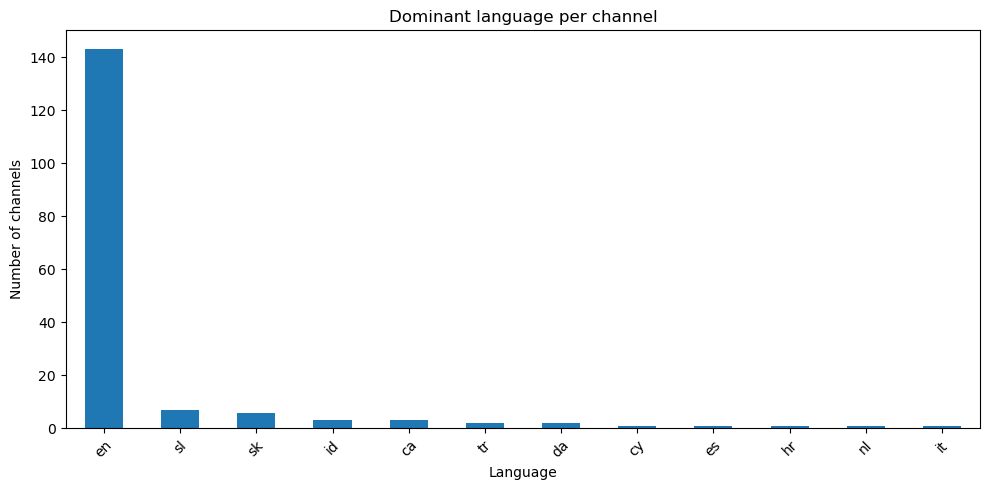

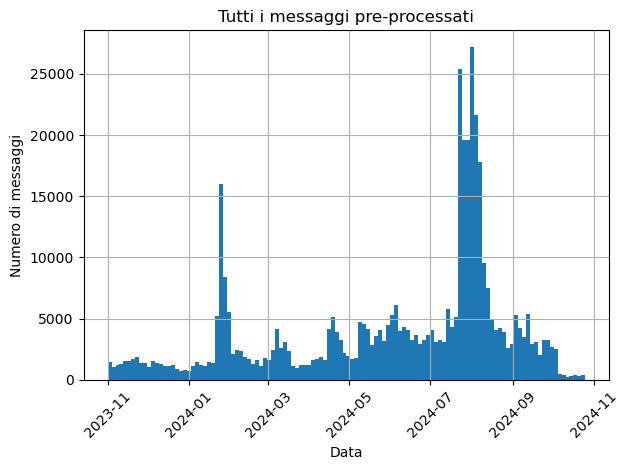

Numero di testi pre-processati: 450014
---
Numero di canali unici: 160
---


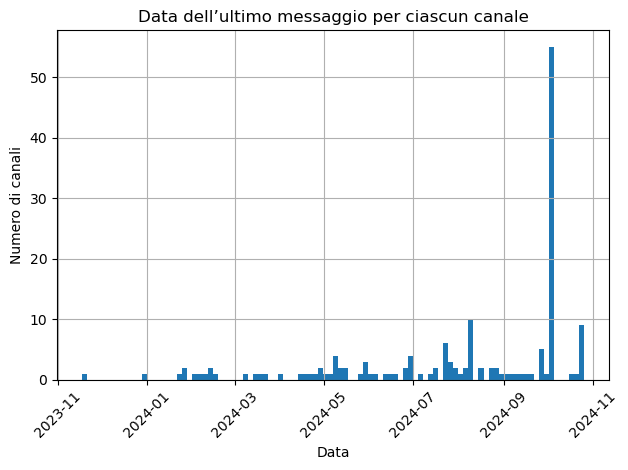

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by channel_id and language, count the number of messages
lang_counts = df_preprocessed_non_empty_channels.groupby(['channel_id', 'language']).size().reset_index(name='count')

# Sort by channel_id and message count in descending order
lang_counts_sorted = lang_counts.sort_values(['channel_id', 'count'], ascending=[True, False])

# Keep only the most frequent language for each channel
dominant_lang = lang_counts_sorted.drop_duplicates(subset='channel_id', keep='first')

# Plot the distribution of dominant languages
plt.figure(figsize=(10, 5))
dominant_lang['language'].value_counts().plot(kind='bar')
plt.title("Dominant language per channel")
plt.xlabel("Language")
plt.ylabel("Number of channels")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Istogram of all the dates of the messages
df_english_preprocessed_non_empty_channels['date'].hist(bins=120)
plt.title("Tutti i messaggi pre-processati")
plt.xlabel("Data")
plt.ylabel("Numero di messaggi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Numero di testi pre-processati:", len(df_english_preprocessed_non_empty_channels['text_preprocessed']))
print("---")
print("Numero di canali unici:", df_english_preprocessed_non_empty_channels['channel_id'].nunique())
print("---")

# Istogramm of the date of the last message for every channel
df_english_preprocessed_non_empty_channels.sort_values(by='date') \
    .drop_duplicates(subset='channel_id', keep='last')['date'] \
    .hist(bins=100)
plt.title("Data dell’ultimo messaggio per ciascun canale")
plt.xlabel("Data")
plt.ylabel("Numero di canali")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
'''
os.environ["TOKENIZERS_PARALLELISM"] = "true"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model_name = 'all-distilroberta-v1'
embedding_model=SentenceTransformer(model_name)

if os.path.exists(f'../final/final_embeddings_{model_name}.npy'):
    print('file found')
    embeddings = np.load(f'../final/final_embeddings_{model_name}.npy')
    print(f'embedding {model_name} loaded')
else:
    embedding_model = embedding_model.to(device)
    embeddings = embedding_model.encode(df_english_preprocessed_non_empty_channels['text_preprocessed'].tolist(), show_progress_bar=True, device=device)
    np.save(f'../final/final_embeddings_{model_name}.npy', embeddings)

print(f"df_english_preprocessed_non_empty_channels['text_preprocessed'].tolist(): {df_english_preprocessed_non_empty_channels['text_preprocessed'].tolist()}")
print(f"embeddings: {embeddings}")

'''

'\nos.environ["TOKENIZERS_PARALLELISM"] = "true"\n\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\nprint(device)\n\nmodel_name = \'all-distilroberta-v1\'\nembedding_model=SentenceTransformer(model_name)\n\nif os.path.exists(f\'../final/final_embeddings_{model_name}.npy\'):\n    print(\'file found\')\n    embeddings = np.load(f\'../final/final_embeddings_{model_name}.npy\')\n    print(f\'embedding {model_name} loaded\')\nelse:\n    embedding_model = embedding_model.to(device)\n    embeddings = embedding_model.encode(df_english_preprocessed_non_empty_channels[\'text_preprocessed\'].tolist(), show_progress_bar=True, device=device)\n    np.save(f\'../final/final_embeddings_{model_name}.npy\', embeddings)\n\nprint(f"df_english_preprocessed_non_empty_channels[\'text_preprocessed\'].tolist(): {df_english_preprocessed_non_empty_channels[\'text_preprocessed\'].tolist()}")\nprint(f"embeddings: {embeddings}")\n\n'

In [10]:
'''
umap_params = {'n_components': 5, 'n_neighbors': 5, 'min_dist': 0.0}
hdbscan_params = {'min_cluster_size': 500,'min_samples':100,'prediction_data':True}

output_path = f'../final/final_{model_name}.pkl'

if not os.path.exists(output_path):
    print(f"debug {len(df_english_preprocessed_non_empty_channels)} messaggi pre-processati.")

    umap_model = UMAP(**umap_params)
    hdbscan_model = HDBSCAN(**hdbscan_params)

    max_features_vectorizer = 1024
    min_df_vectorizer = 0.01
    max_df_vectorizer = 0.99 

    vectorizer_model = CountVectorizer(
        max_features=max_features_vectorizer, 
        min_df=min_df_vectorizer,
        max_df=max_df_vectorizer
    )

    print("embeddings.shape", embeddings.shape)

    t0 = time.time()
    topic_model = BERTopic(
        embedding_model=None,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        verbose=True,
        top_n_words=20,
        language='english', 
        vectorizer_model=vectorizer_model
    )

    print("embedding shape 0" + str(embeddings.shape[0]))
    print("embedding first", embeddings[0])
    print("len df "+ str(len(df_english_preprocessed_non_empty_channels['text_preprocessed'])))
    assert embeddings.shape[0] == len(df_english_preprocessed_non_empty_channels['text_preprocessed'])

    topics, probs = topic_model.fit_transform(df_english_preprocessed_non_empty_channels['text_preprocessed'], embeddings=embeddings)
    print(f"Execution time for {model_name} UMAP: {time.time()-t0}s")

    topics = np.array(topics)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    
    topic_model.save(output_path)
else:
    print(f"Model already saved at {output_path}")

topic_model=BERTopic.load(f'../final/final_{model_name}.pkl')
topics=np.array(topic_model.topics_)

'''

'\numap_params = {\'n_components\': 5, \'n_neighbors\': 5, \'min_dist\': 0.0}\nhdbscan_params = {\'min_cluster_size\': 500,\'min_samples\':100,\'prediction_data\':True}\n\noutput_path = f\'../final/final_{model_name}.pkl\'\n\nif not os.path.exists(output_path):\n    print(f"debug {len(df_english_preprocessed_non_empty_channels)} messaggi pre-processati.")\n\n    umap_model = UMAP(**umap_params)\n    hdbscan_model = HDBSCAN(**hdbscan_params)\n\n    max_features_vectorizer = 1024\n    min_df_vectorizer = 0.01\n    max_df_vectorizer = 0.99 \n\n    vectorizer_model = CountVectorizer(\n        max_features=max_features_vectorizer, \n        min_df=min_df_vectorizer,\n        max_df=max_df_vectorizer\n    )\n\n    print("embeddings.shape", embeddings.shape)\n\n    t0 = time.time()\n    topic_model = BERTopic(\n        embedding_model=None,\n        umap_model=umap_model,\n        hdbscan_model=hdbscan_model,\n        verbose=True,\n        top_n_words=20,\n        language=\'english\', \n   

In [11]:
#from cuml.cluster import HDBSCAN
#from cuml.manifold import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence


df_sampled = df_english_preprocessed_non_empty_channels.sample(frac=0.1)

texts=[sentence.split() for sentence in df_sampled['text_preprocessed'].to_list()]
'''
texts = [
    ["i", "love", "machine", "learning"],
    ["data", "science", "is", "fun"],
    ["deep", "learning", "models", "are", "powerful"]
]*/
'''
def get_metrics(topic_model,texts=texts):
    '''
    Return: diversity_score,coherence_score
    '''
    topics = topic_model.get_topics()
    '''
    topics={
    0: [('apple', 0.3), ('banana', 0.2), ...],
    1: [('data', 0.4), ('science', 0.3), ...],
    ...
    }
    '''
    topics_list = []
    for topic_id, topic_words in topics.items():
        '''
        topic_words=[('apple', 0.3), ('banana', 0.2), ...]
        '''
        if topic_id!=-1:
            # Take words for each topic where >= 10
            words=[word[0] for word in topic_words if word[0]!='']
            if len(words)>=10:
                topics_list.append(words)  # Extracting only words from (word, probability)

    #topics_list = [["apple", "banana",...], ["data", "science"...], ...]
    # Wrap the topics into the expected format
    model_output = {"topics": topics_list}

    '''
    model_output = {
    "topics": [
        ["apple", "banana", ...],
        ["data", "science", ...],
        ...
    ]
    }
    '''
    

    # Now calculate diversity using the correct format
    topic_diversity = TopicDiversity(topk=10)  # Specify how many top words you want to consider
    diversity_score = topic_diversity.score(model_output)  # Pass the wrapped topics

    # Calculate coherence score
    coherence_metric = Coherence(topk=10,texts=texts)  # Specify top_n for coherence calculation
    coherence_score = coherence_metric.score(model_output)  # Pass the wrapped topics
    print(coherence_score)
    return diversity_score,coherence_score

# Step 2: Set device
os.environ["TOKENIZERS_PARALLELISM"] = "true"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# List of SentenceTransformer models
models = {
    'all-distilroberta-v1': SentenceTransformer('all-distilroberta-v1'),
    'paraphrase-MiniLM-L6-v2': SentenceTransformer('paraphrase-MiniLM-L6-v2'),
    'all-MiniLM-L6-v2': SentenceTransformer('all-MiniLM-L6-v2')
}

# Step 3: Precompute embeddings for each model


# Step 4: Define grid search for UMAP and HDBSCAN parameters
umap_params = [
    {'n_components': 5, 'n_neighbors': 5, 'min_dist': 0.0},
    {'n_components': 5, 'n_neighbors': 25, 'min_dist': 0.0},
    {'n_components': 5, 'n_neighbors': 125, 'min_dist': 0.0},
    
    {'n_components': 5, 'n_neighbors': 5, 'min_dist': 0.1},
    {'n_components': 5, 'n_neighbors': 25, 'min_dist': 0.1},
    {'n_components': 5, 'n_neighbors': 125, 'min_dist': 0.1},
]

hdbscan_params = [
    {'min_cluster_size': 100},
    {'min_cluster_size': 500}
     ]

# Step 5: Check if results already exist
if os.path.exists('../final/grid_search_results.csv'):
    results_df = pd.read_csv('../final/grid_search_results.csv')
else:
    results_df = pd.DataFrame(columns=['model',
                'umap_n_components',
                'umap_n_neighbors',
                'umap_min_dist',
                'hdbscan_min_cluster_size',
                'coherence',
                'diversity',
                'silhouette'])

# Initialize the results list
results = []

# Step 6: Perform grid search
best_score = -1
best_model = None
best_params = None

'''
models = {
    'all-distilroberta-v1': SentenceTransformer('all-distilroberta-v1'),
    'paraphrase-MiniLM-L6-v2': SentenceTransformer('paraphrase-MiniLM-L6-v2'),
    'all-MiniLM-L6-v2': SentenceTransformer('all-MiniLM-L6-v2')
}

umap_params = [
    {'n_components': 3, 'n_neighbors': 5, 'min_dist': 0.0},
    {'n_components': 3, 'n_neighbors': 25, 'min_dist': 0.0},
]
'''
for model_name, model_instance in tqdm(models.items()):
    # for every possible model of Sentence Transformer
    if os.path.exists(f'../final/final_embeddings_{model_name}.npy'):
        embeddings = np.load(f'../final/final_embeddings_{model_name}.npy')
        print(f'embedding {model_name} loaded')
    else:
        model_instance = model_instance.to(device)
        embeddings = model_instance.encode(df_sampled['text_preprocessed'].tolist(), show_progress_bar=True, device=device)
        np.save(f'../final/final_embeddings_{model_name}.npy', embeddings)
    
    for umap_config in umap_params:
        for hdbscan_config in hdbscan_params:
            # Check if this combination has already been run
            '''
                results_df = pd.DataFrame(columns=[
                'model',
                'umap_n_components',
                'umap_n_neighbors',
                'umap_min_dist',
                'hdbscan_min_cluster_size',
                'coherence',
                'diversity',
                'silhouette'])
            '''
            if ((len(results_df)>0) and
                ((results_df['model'] == model_name) &
                (results_df['umap_n_components'] == umap_config['n_components']) &
                (results_df['umap_n_neighbors'] == umap_config['n_neighbors']) &
                (results_df['umap_min_dist'] == umap_config['min_dist']) &
                (results_df['hdbscan_min_cluster_size'] == hdbscan_config['min_cluster_size'])).any()):
                print(f"Skipping already tested configuration: {model_name} with UMAP {umap_config} and HDBSCAN {hdbscan_config}")
                continue

            # Initialize UMAP and HDBSCAN models with current parameters
            umap_model = UMAP(**umap_config)
            hdbscan_model = HDBSCAN(**hdbscan_config)
            
            # Step 7: Apply UMAP and HDBSCAN to the embeddings
            t0 = time.time()
            topic_model = BERTopic(
                embedding_model=None,
                umap_model=umap_model,
                hdbscan_model=hdbscan_model,
                verbose=True,
                top_n_words=20,
                language = 'english',
            )
            
            topics, probs = topic_model.fit_transform(df_sampled['text_preprocessed'],embeddings=embeddings)
            print(f"Execution time for {model_name} UMAP: {time.time()-t0}s")
            
            topics=np.array(topics)
            
            
            # Step 8: Save the model
            model_filename = f'../final/bertopic_models/{model_name}_umap{umap_config["n_components"]}_umap{umap_config["n_neighbors"]}_umap{umap_config["min_dist"]}_hdbscan{hdbscan_config["min_cluster_size"]}.pkl'
            topic_model.save(model_filename)

            # Step 9: Compute evaluation metrics
            diversity,coherence=get_metrics(topic_model)
            
            
            umap_model = topic_model.umap_model
            reduced_embedding=umap_model.transform(embeddings)
            topics=np.array(topic_model.topics_)
            silhouette=silhouette_score(reduced_embedding[topics!=-1],topics[topics!=-1])
            
            # Store the best model based on silhouette score
            avg_score = (coherence + diversity + silhouette) / 3
            
            if avg_score > best_score:
                best_score = avg_score
                best_model = topic_model


           
            topics=pd.Series(topics)
            
            # Step 10: Log the results
            results.append({
                'model': model_name,
                'umap_n_components': umap_config['n_components'],
                'umap_n_neighbors': umap_config['n_neighbors'],
                'umap_min_dist': umap_config['min_dist'],
                'hdbscan_min_cluster_size': hdbscan_config['min_cluster_size'],
                'coherence': coherence,
                'diversity': diversity,
                'silhouette': silhouette,
                'n_outliers':(topics==-1).sum(),
                'n_topics':topics.nunique()-1,
                'min_topic':topics.value_counts().min(),
                'max_topic':topics.value_counts().max(),
                
                })
            print(results[-1])
                
                
            pd.concat([results_df, pd.DataFrame(results)], ignore_index=True).to_csv('../final/grid_search_results.csv', index=False)
                


cpu



  0%|          | 0/3 [00:00<?, ?it/s]

embedding all-distilroberta-v1 loaded


ValueError: Make sure that the embeddings are a numpy array with shape: (len(docs), vector_dim) where vector_dim is the dimensionality of the vector embeddings. 

In [ ]:
import pandas as pd
from bertopic import BERTopic

df_grid = pd.read_csv("../final/grid_search_results.csv")
df_grid['avg_score'] = (df_grid['silhouette'] + df_grid['coherence'] + df_grid['diversity'])/3

best_models = {
    'silhouette': df_grid.sort_values(by='silhouette', ascending=False).iloc[0],
    'coherence': df_grid.sort_values(by='coherence', ascending=False).iloc[0],
    'diversity': df_grid.sort_values(by='diversity', ascending=False).iloc[0],
    'avg_score': df_grid.sort_values(by='avg_score', ascending=False).iloc[0]
}

#load the corresponding BERTopics
topic_models = {}
for key, row in best_models.items():
    model_filename = f"../final/bertopic_models/{row['model']}_umap{row['umap_n_components']}_umap{row['umap_n_neighbors']}_umap{row['umap_min_dist']}_hdbscan{row['hdbscan_min_cluster_size']}.pkl"
    print(f"Loading model for best {key} from: {model_filename}")
    print(row)
    topic_models[key] = BERTopic.load(model_filename)
    topic_models[key].visualize_barchart(top_n_topics=-1,n_words=20, width = 350,height=450).show()

#top_n_topics=-1	Mostra tutti i topic (eccetto outlier -1)	top_n_topics=5 mostrerebbe solo i primi 5 topic più grandi
#n_words=20	Mostra 20 parole per ogni topic nel grafico	Se vuoi vederne solo 10, metti n_words=10
#width=350	Larghezza (in pixel) del grafico	Cambia la dimensione orizzontale del plot
#height=450	Altezza (in pixel) del grafico	Cambia la dimensione verticale del plot

'''
df_grid = pd.read_csv("../final/grid_search_results.csv")
df_grid['avg_score'] = (df_grid['silhouette'] + df_grid['coherence'] + df_grid['diversity'])/3
model_with_top_silouette = df_grid.sort_values(by='silhouette').iloc[-1]
print(model_with_top_silouette)
print("----")
model_with_top_coherence = df_grid.sort_values(by='coherence').iloc[-1]
print(model_with_top_coherence)
print("----")
model_with_top_diversity = df_grid.sort_values(by='diversity').iloc[-1]
print(model_with_top_diversity)
print("---")
model_with_top_avg_score = df_grid.sort_values(by='avg_score').iloc[-1]
print(model_with_top_avg_score)
'''

In [ ]:
texts = df_english_preprocessed_non_empty_channels['text_preprocessed']
timestamps = pd.to_datetime(df_english_preprocessed_non_empty_channels['date'],format="%Y-%m-%d")

topics_over_time = topic_model.topics_over_time(
    list(df_english_preprocessed_non_empty_channels['text_preprocessed']),
    list(df_english_preprocessed_non_empty_channels['date']),
    nr_bins = timestamps.nunique(),
    global_tuning = False,
    evolution_tuning = True)


In [ ]:

fig = topic_model.visualize_topics_over_time(
    topics_over_time,
    top_n_topics=5
)

distinct_colors = px.colors.qualitative.Alphabet

for i, trace in enumerate(fig.data):
    if i < len(distinct_colors):
        trace.line.color = distinct_colors[i]

fig.show()


- reduce outliers

In [ ]:
umap_model=topic_model.umap_model
reduced_embeddings=umap_model.transform(embeddings)

new_topics = topic_model.reduce_outliers(list(texts), topics , strategy="c-tf-idf", threshold=0.1)

#Quando BERTopic prova a riassegnare un outlier, confronta il suo contenuto testuale con i topic usando una misura di similarità tra vettori TF-IDF.
#Di solito si tratta di una similarità coseno, che varia tra:
#0.0 = nessuna somiglianza
#1.0 = perfetta somiglianza
#0.1 è molto poco

topic_model.update_topics(list(texts), topics=new_topics,
                          vectorizer_model=vectorizer_model,top_n_words=20)
topic_model.get_topic_info()


In [ ]:
new_topics=np.array(new_topics)
pd.Series(new_topics).value_counts(normalize=True)